In [1]:
import numpyro
numpyro.set_platform('cpu')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import jax.numpy as jnp

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(context='paper', style='white', font_scale=1.6, color_codes=True)

In [3]:
def plot_performance(results, num_epochs, ylims=[[.7, .95]]):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)

    for key in results:
        vals = results[key]
        if vals is not None:
            for ax, lbl in zip(axes, ['acc', 'ece', 'nll']):
                ax.plot(range(1, num_epochs + 1), vals[lbl], 'o:', label=key)
                ax.set_xlabel('epoch')
                ax.set_title(lbl)

    axes[0].legend(title='method', fontsize=12)
    for i, ylim in enumerate(ylims):
        axes[i].set_ylim(ylim)
    fig.tight_layout()

    return fig

def plot_compression(results, num_epochs, labels=['mlp', 'lenet', 'resnet', 'vit']):
    fig, axes = plt.subplots(1, len(labels), figsize=(16, 4), sharex=True, sharey=True)

    for i, label in enumerate(labels):
        try:
            for key in results[label]:
                vals = results[label][key]
                try:
                    axes[i].plot(range(num_epochs), vals['zip'], 'o:', label=key)
                except:
                    pass
        except:
            pass

    for ax in axes:
        ax.set_xlabel('epoch')

    axes[0].set_ylabel('pruned fraction')
    axes[0].set_ylim([0, 1])
    axes[0].set_title('MLP-100x5')
    axes[1].set_title('LeNet-120-84-10')
    axes[2].set_title('ResNet18')
    axes[3].set_title('ViT-T')


    axes[0].legend(title='method')
    fig.tight_layout()

    return fig

In [4]:
# load results
fm_results = jnp.load('../results/fashion_mnist.npz', allow_pickle=True)['results'].item()

#  c10_results = jnp.load('../results/cifar10.npz', allow_pickle=True)['results'].item()

# c100_results = jnp.load('../results/cifar100.npz', allow_pickle=True)['results'].item()

num_epochs = 5

# DenseNet

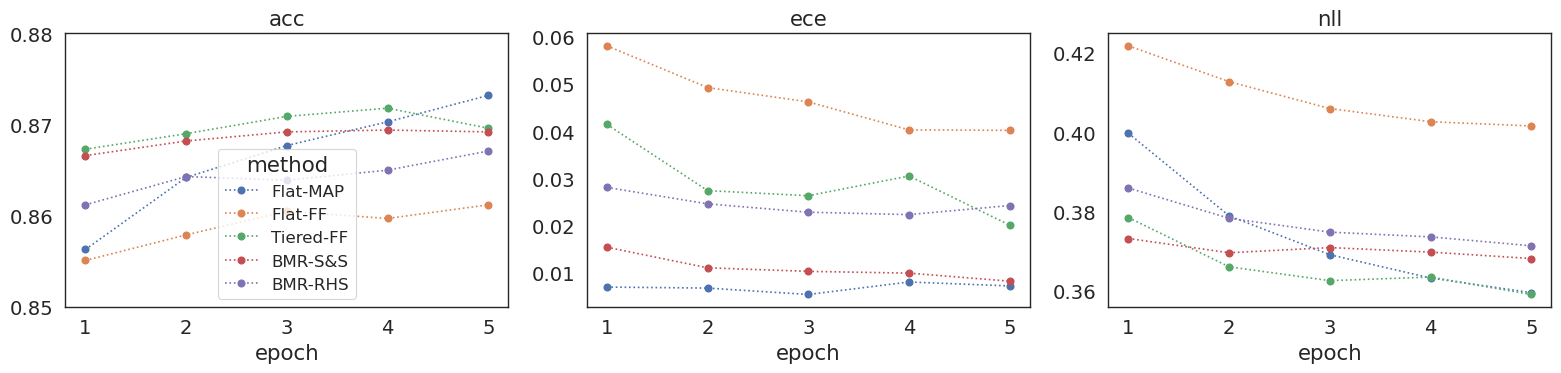

In [8]:
plot_performance( fm_results['mlp'], num_epochs, ylims=[[.85, .88]] );

In [6]:
plot_performance( c10_results['mlp'], num_epochs );

KeyError: 'dense'

## LeNet

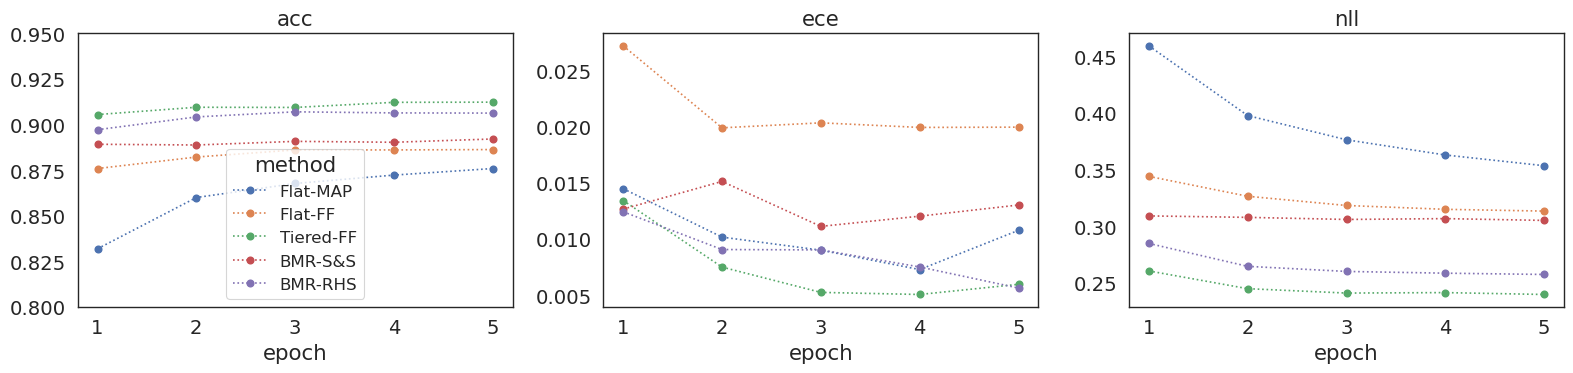

In [6]:
plot_performance( fm_results['lenet'], num_epochs, ylims=[[.8, .95]] );

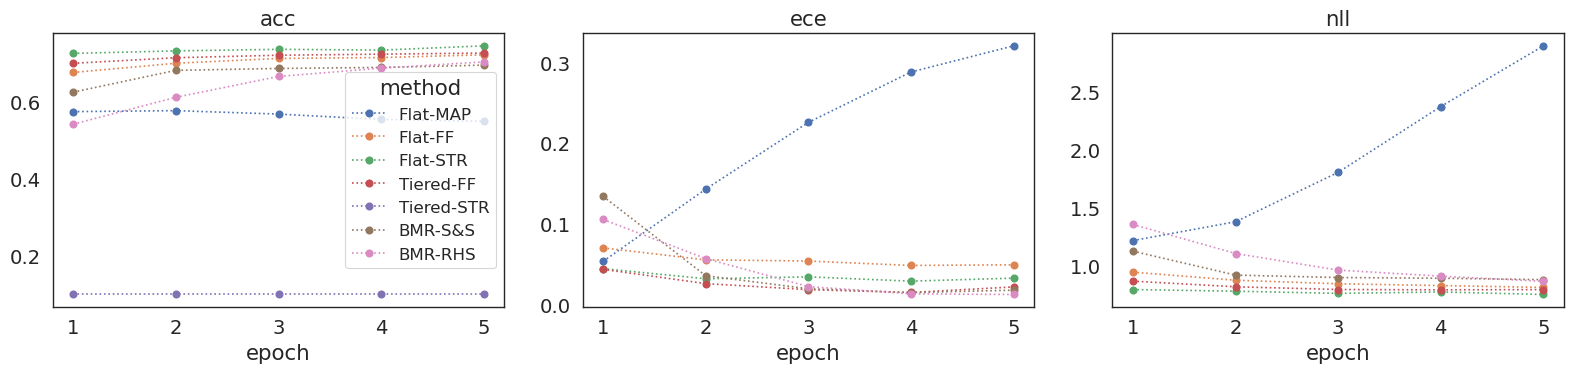

In [7]:
plot_performance( c10_results['lenet'], num_epochs );

# ViT

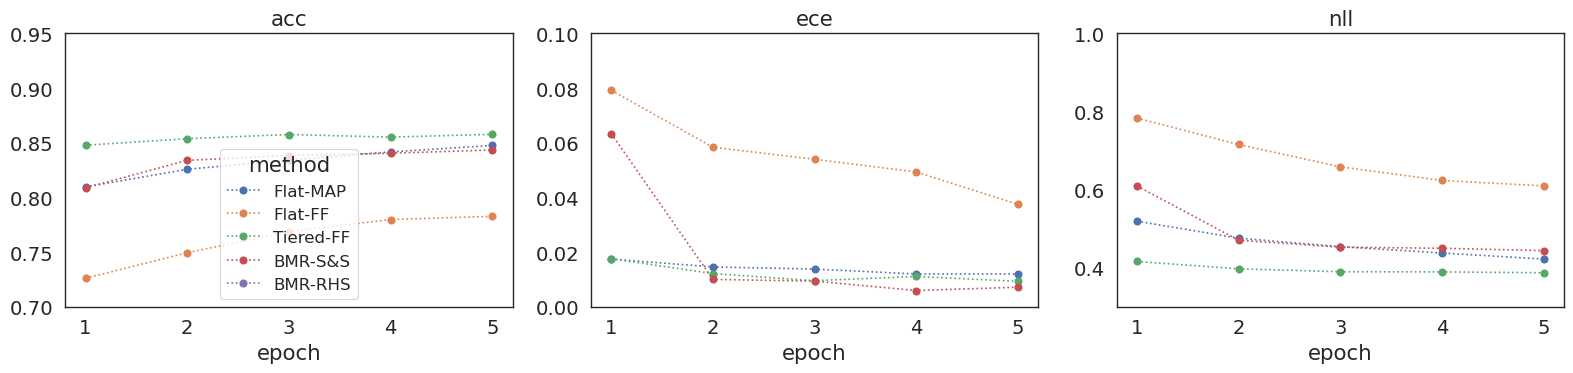

In [22]:
plot_performance( fm_results['vit'], num_epochs, ylims=[[.7, .95], [0, .1], [0.3, 1]] );

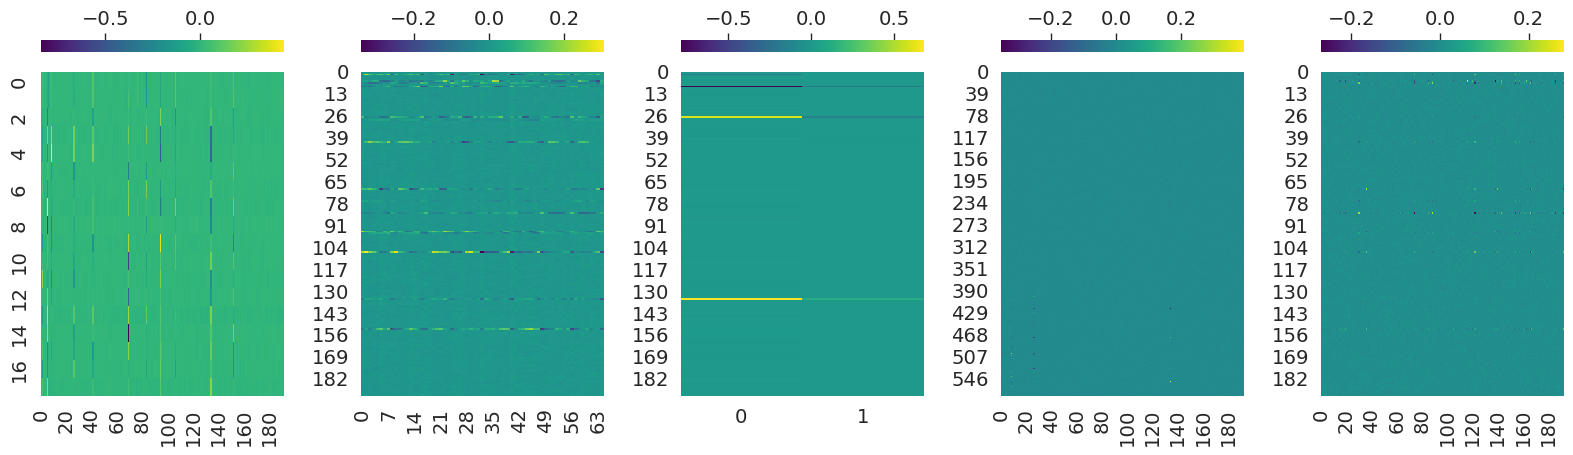

In [65]:
fig, axes = plt.subplots(1, 5, figsize=(16, 5))
for i in range(5):
    sns.heatmap(fm_results['vit']['Flat-FF']['samples'][f'layer{i}.weight'].mean(0), cmap='viridis', ax=axes[i], cbar_kws=dict(location="top"))

fig.tight_layout()

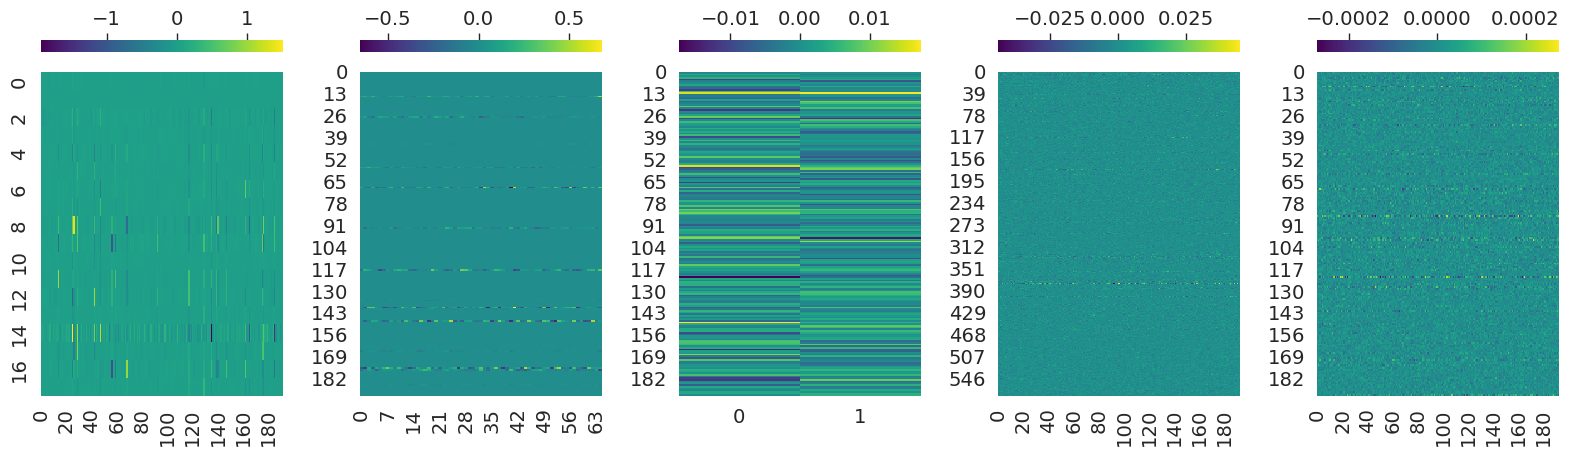

In [36]:
fig, axes = plt.subplots(1, 5, figsize=(16, 5))
for i in range(5):
    sns.heatmap(fm_results['vit']['Tiered-FF']['samples'][f'layer{i}.weight'].mean(0), cmap='viridis', ax=axes[i], cbar_kws=dict(location="top"))

fig.tight_layout()

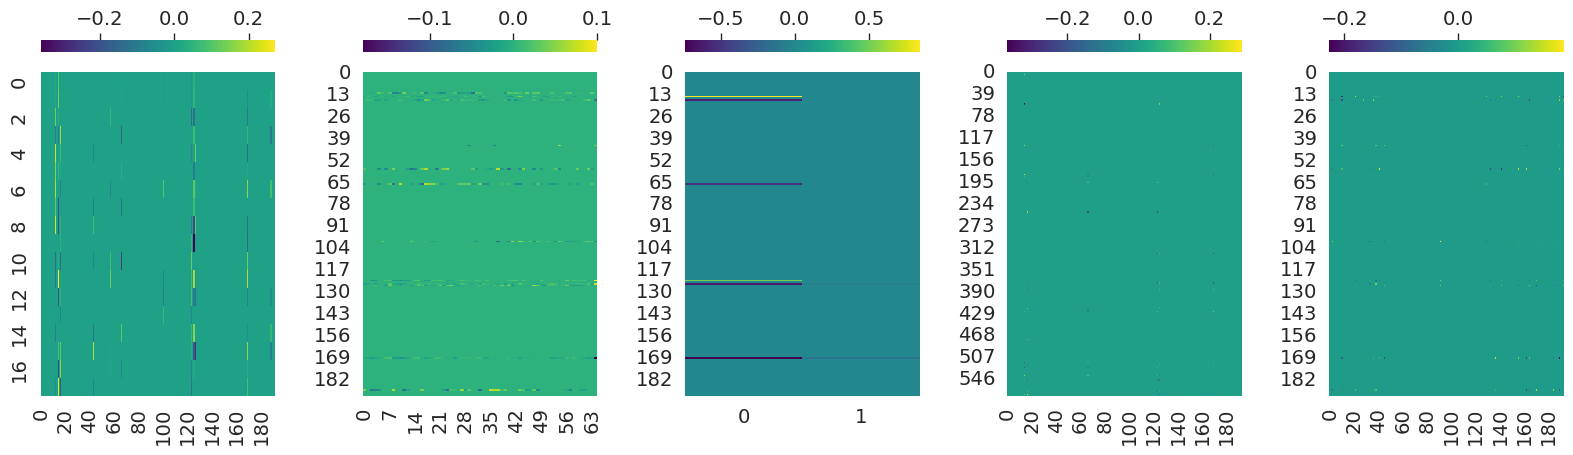

In [66]:
fig, axes = plt.subplots(1, 5, figsize=(16, 5))
for i in range(5):
    sns.heatmap(fm_results['vit']['BMR-S&S']['samples'][f'layer{i}.weight'].mean(0), cmap='viridis', ax=axes[i], cbar_kws=dict(location="top"))

fig.tight_layout()

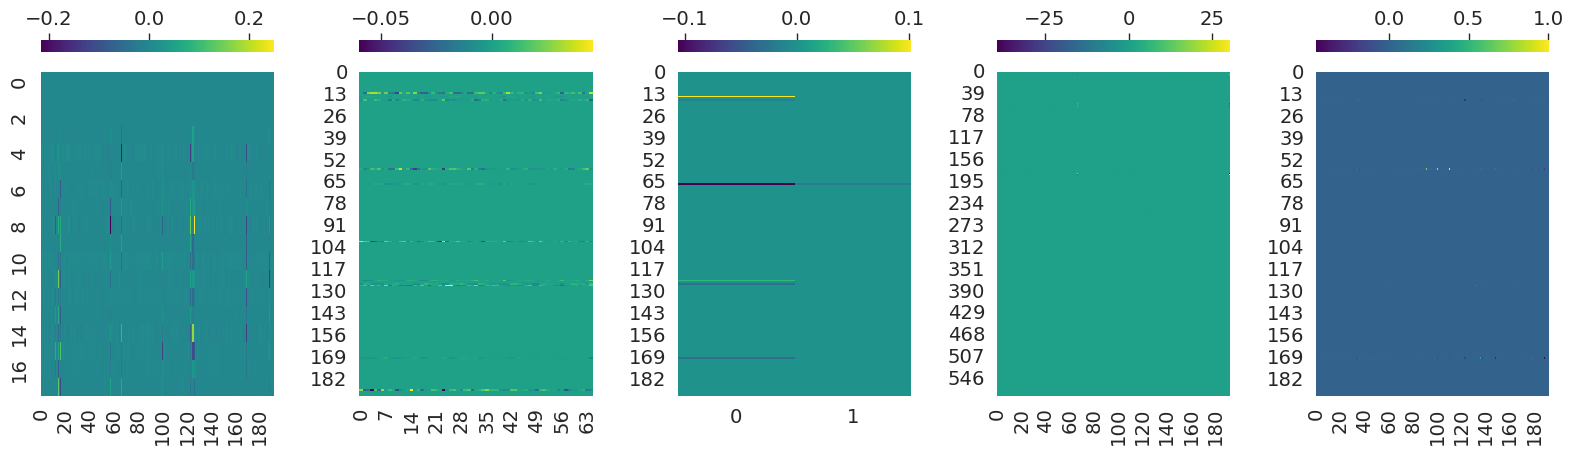

In [37]:
fig, axes = plt.subplots(1, 5, figsize=(16, 5))
for i in range(5):
    sns.heatmap(fm_results['vit']['BMR-RHS']['samples'][f'layer{i}.weight'].mean(0), cmap='viridis', ax=axes[i], cbar_kws=dict(location="top"))

fig.tight_layout()

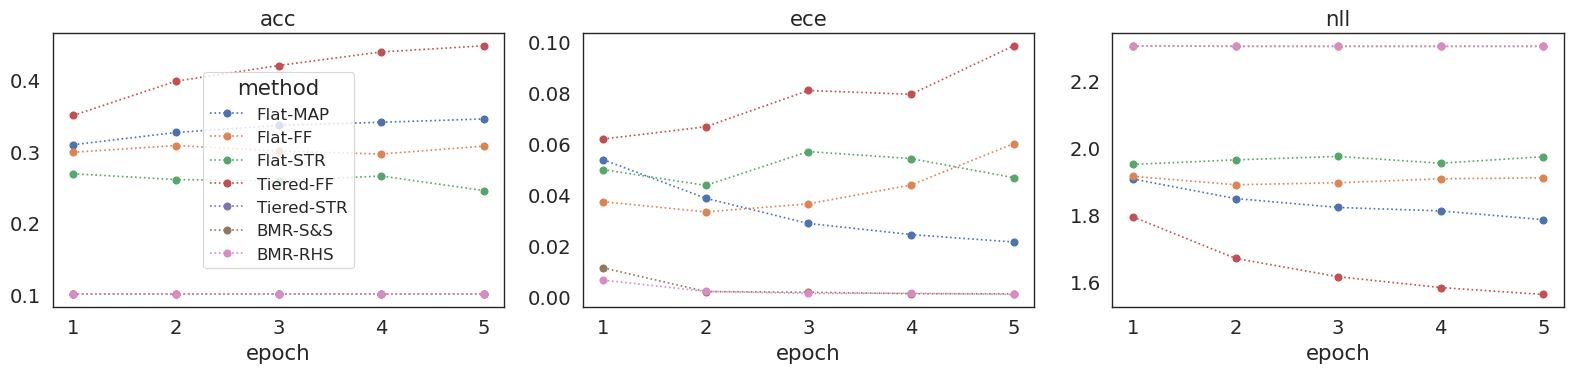

In [5]:
plot_performance( c10_results['vit'], num_epochs );

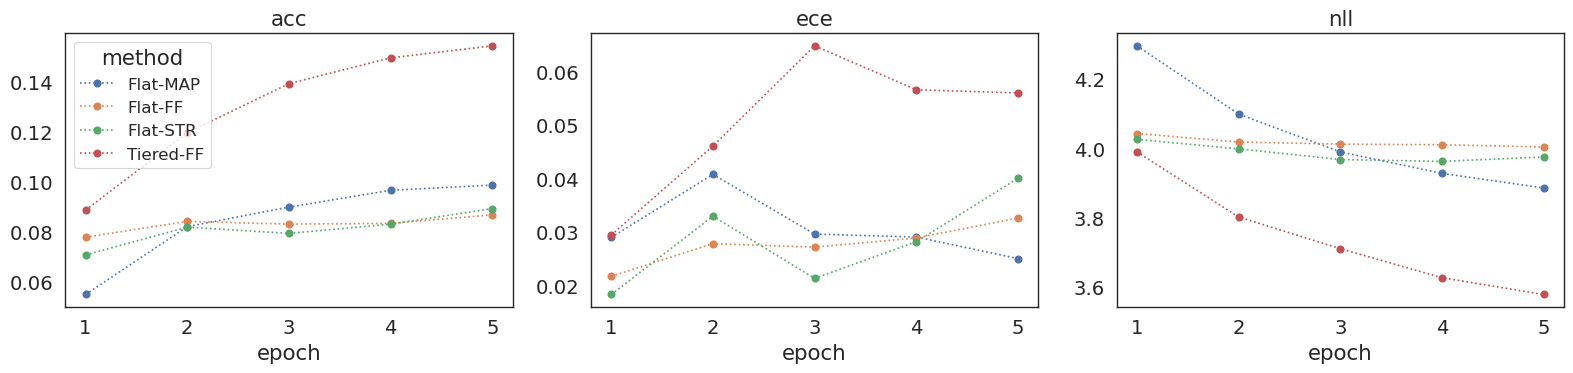

In [8]:
plot_performance( c100_results['vit'], num_epochs );

# ResNet

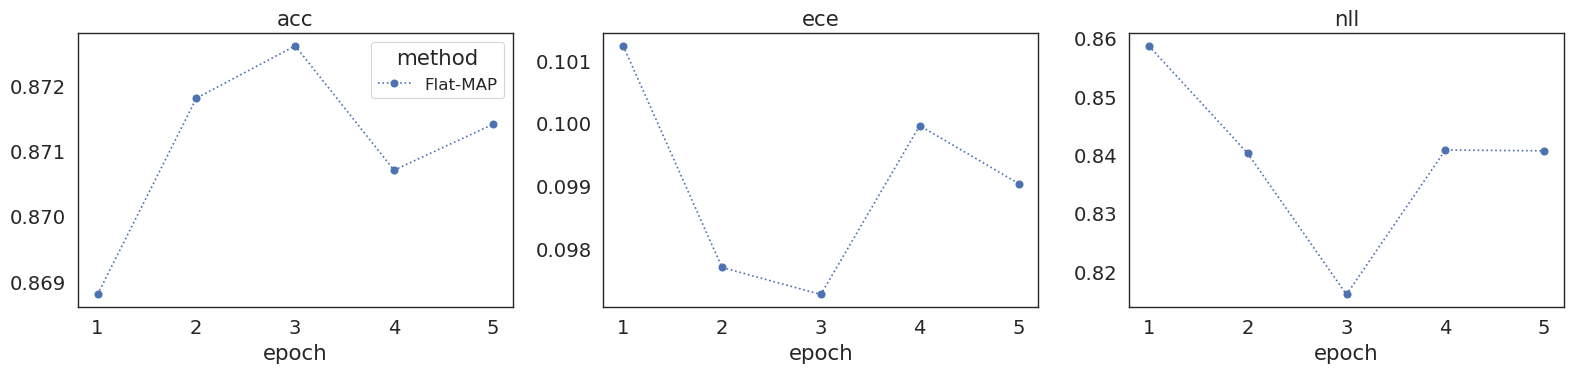

In [14]:
plot_performance( fm_results['resnet'], num_epochs );

# Bayesian compression

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


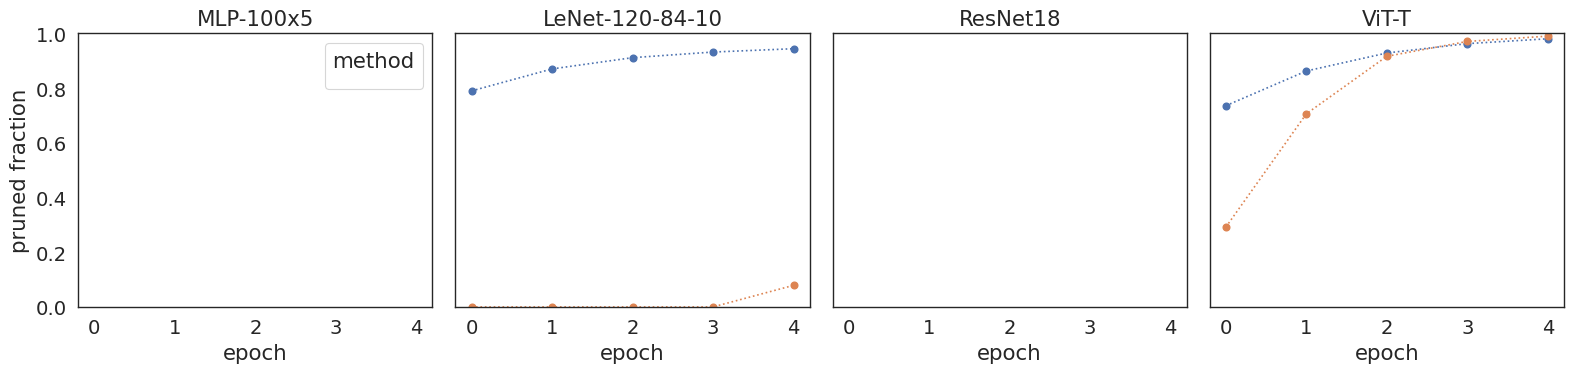

In [71]:
plot_compression(fm_results, num_epochs);

KeyError: 'dense'

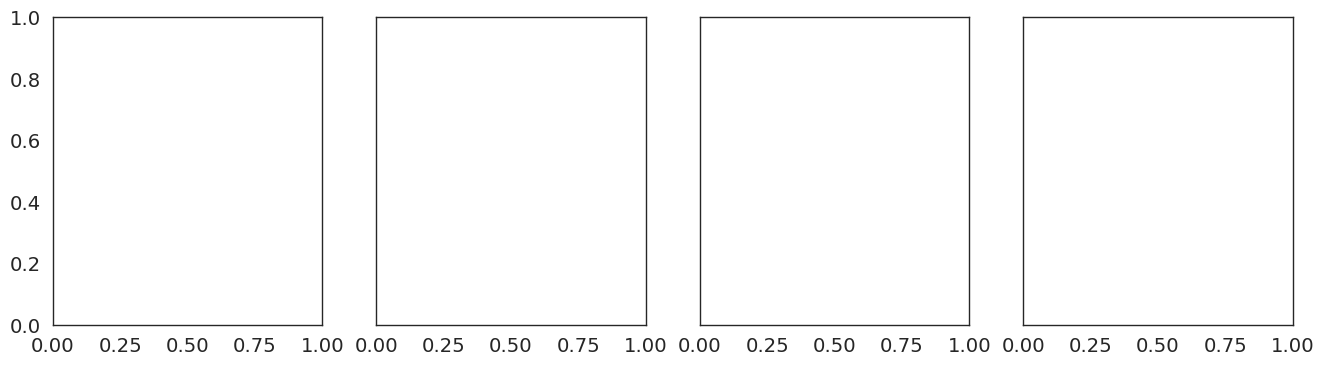

In [6]:
plot_compression(c10_results, num_epochs);

IndexError: index 2 is out of bounds for axis 0 with size 2

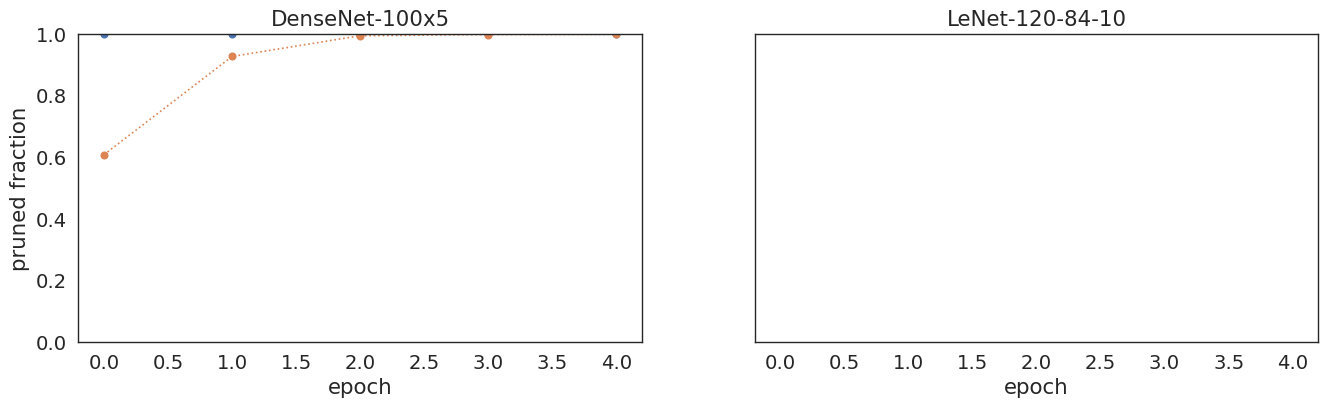

In [11]:
plot_compression(c100_results, num_epochs, labels=['dense', 'vit']);